In [1]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dt
import math

In [2]:
images = np.genfromtxt("/Users/ozlemserifogullari/Documents/ENGR421/HW6/hw06_data_set_images.csv", delimiter = ",", skip_header = 0)
classes = np.genfromtxt("/Users/ozlemserifogullari/Documents/ENGR421/HW6/hw06_data_set_labels.csv", delimiter = ",", skip_header = 0)

train_indices = np.arange(0,1000)
test_indices = np.arange(1000,2000)
x_train = images[train_indices,:]
y_train = classes[train_indices]
x_test = images[test_indices,:]
y_test = classes[test_indices]

N = len(x_train)
D = len(x_train[0])
K = 2 # 1 and -1

N_test = len(x_test)

color_size = 256 # the maximum value of a pixel can have


1000 784 2 1000


In [3]:
def calculate_hist(x, no_bins, no_pixels, no):
    result = np.zeros((no, no_bins))
    bin_width = 256 / no_bins
    left_borders = np.arange(0, 256, bin_width)
    right_borders = np.arange(0 + bin_width, 256 + bin_width , bin_width)
    for i in range(no_bins):
        for j in range(no):
            result[j][i] = np.sum([1 if x[j][d] >= left_borders[i] and x[j][d] < right_borders[i] else 0 for d in range(no_pixels)]) / no_pixels
    
    return result

L = 64
H_train = calculate_hist(x_train, L, D, N)
H_test = calculate_hist(x_test, L, D, N_test)

print(H_train[0:5, 0:5])
print(H_test[0:5, 0:5])  


print(H_train[0:5, 0:5])
print(H_test[0:5, 0:5])
[[0.86479592 0.00127551 0.         0.00255102 0.        ]
 [0.66836735 0.         0.00127551 0.00127551 0.        ]
 [0.66454082 0.00637755 0.00382653 0.00765306 0.00892857]
 [0.65816327 0.00765306 0.00892857 0.00127551 0.00382653]
 [0.5625     0.00255102 0.00255102 0.00127551 0.        ]]
[[0.68239796 0.00255102 0.00127551 0.00127551 0.00127551]
 [0.69770408 0.01658163 0.00510204 0.00382653 0.01020408]
 [0.73341837 0.02678571 0.01530612 0.00510204 0.00637755]
 [0.63903061 0.00892857 0.00255102 0.00127551 0.        ]
 [0.75382653 0.00765306 0.00127551 0.00127551 0.        ]]


In [4]:
def hist_intersection(h1, h2, l):
    K = np.zeros((len(h1), len(h2)))
    for r1 in range (len(h1)):
            for r2 in range (len(h2)):
                sum = 0
                for bin in range(l):
                    sum += min(h1[r1][bin], h2[r2][bin])
                K[r1][r2] = sum
    return K
                            
K_train = hist_intersection(H_train, H_train, L)
K_test = hist_intersection(H_test, H_train, L)

print(K_train[0:5, 0:5])
print(K_test[0:5, 0:5]) 

[[1.         0.72321429 0.77040816 0.75382653 0.62755102]
 [0.72321429 1.         0.73086735 0.78571429 0.68622449]
 [0.77040816 0.73086735 1.         0.84056122 0.70153061]
 [0.75382653 0.78571429 0.84056122 1.         0.76403061]
 [0.62755102 0.68622449 0.70153061 0.76403061 1.        ]]
[[0.77806122 0.80867347 0.82142857 0.88647959 0.79209184]
 [0.79464286 0.76403061 0.84566327 0.86607143 0.77933673]
 [0.8380102  0.74362245 0.85714286 0.83035714 0.68877551]
 [0.71556122 0.84438776 0.75       0.83418367 0.75765306]
 [0.84438776 0.76785714 0.82397959 0.84183673 0.73469388]]


In [5]:
def qp_problem(K, C, no, y, epsilon):
    yyK = np.matmul(y_train[:,None], y_train[None,:]) * K

    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((no, 1)))
    G = cvx.matrix(np.vstack((-np.eye(no), np.eye(no))))
    h = cvx.matrix(np.vstack((np.zeros((no, 1)), C * np.ones((no, 1)))))
    A = cvx.matrix(1.0 * y[None,:])
    b = cvx.matrix(0.0)

    # use cvxopt library to solve QP problems
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C

    # find bias parameter
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))

    return alpha, w0

def svm_predict(K, y, alpha, w0):
    # calculate predictions on training samples
    f_predicted = np.matmul(K, y[:,None] * alpha[:,None]) + w0

    # calculate confusion matrix
    y_predicted = 2 * (f_predicted > 0.0) - 1
    
    return y_predicted

def print_confusion_matrix(y_truth, y_pred, no):
    confusion_matrix = pd.crosstab(np.reshape(y_pred, no), y_truth,
                               rownames = ["y_predicted"], colnames = ["y_train"])
    print(confusion_matrix)


In [6]:
alpha, w0 = qp_problem(K_train, 10, N, y_train, 0.001)

y_pred_train = svm_predict(K_train, y_train, alpha, w0)
print_confusion_matrix(y_train, y_pred_train, N)

y_pred_test = svm_predict(K_test, y_train, alpha, w0)
print_confusion_matrix(y_test, y_pred_test, N_test)

     pcost       dcost       gap    pres   dres
 0:  1.0887e+03 -6.1913e+04  1e+05  5e-01  5e-14
 1:  1.2396e+03 -1.1654e+04  1e+04  6e-14  4e-14
 2: -4.1568e+02 -3.9854e+03  4e+03  2e-13  3e-14
 3: -8.3426e+02 -2.5760e+03  2e+03  1e-13  3e-14
 4: -1.0562e+03 -1.7960e+03  7e+02  4e-14  4e-14
 5: -1.2018e+03 -1.4485e+03  2e+02  4e-14  5e-14
 6: -1.2586e+03 -1.3270e+03  7e+01  4e-14  5e-14
 7: -1.2782e+03 -1.2901e+03  1e+01  2e-13  5e-14
 8: -1.2826e+03 -1.2831e+03  5e-01  1e-13  5e-14
 9: -1.2828e+03 -1.2828e+03  1e-02  7e-15  6e-14
10: -1.2828e+03 -1.2828e+03  2e-04  9e-14  6e-14
Optimal solution found.
y_train      -1.0   1.0
y_predicted            
-1            484     9
 1              9   498
y_train      -1.0   1.0
y_predicted            
-1            466    25
 1             37   472


In [7]:
def calculate_accuracy(y_truth, y_pred, no):
    accuracy = 0
    no = y_truth.shape[0]
    
    for i in range(no):
        if y_truth[i] == y_pred[i]:
            accuracy += 1
    
    return accuracy / no

c_array = np.array([pow(10,-1), pow(10, -0.5), pow(10, 0), pow(10, 0.5), pow(10, 1), pow(10, 1.5), pow(10, 2), pow(10, 2.5), pow(10, 3)])
train_acc = []
test_acc = []

for c in c_array:
    alpha, w0 = qp_problem(K_train, c, N, y_train, 0.001)
    y_pred_train = svm_predict(K_train, y_train, alpha, w0)
    acc = calculate_accuracy(y_train, y_pred_train, N)
    train_acc.append(acc)
    
    y_pred_test = svm_predict(K_test, y_train, alpha, w0)
    acc = calculate_accuracy(y_test, y_pred_test, N_test)
    test_acc.append(acc)


     pcost       dcost       gap    pres   dres
 0: -1.8751e+02 -2.4438e+02  7e+03  3e+01  5e-15
 1: -6.2127e+01 -2.2353e+02  5e+02  1e+00  4e-15
 2: -4.8341e+01 -1.2857e+02  8e+01  2e-15  2e-15
 3: -5.3798e+01 -6.6369e+01  1e+01  4e-16  1e-15
 4: -5.7212e+01 -6.1182e+01  4e+00  2e-16  9e-16
 5: -5.8516e+01 -5.9343e+01  8e-01  7e-16  1e-15
 6: -5.8814e+01 -5.8991e+01  2e-01  2e-15  1e-15
 7: -5.8883e+01 -5.8910e+01  3e-02  4e-15  1e-15
 8: -5.8895e+01 -5.8897e+01  2e-03  4e-16  1e-15
 9: -5.8896e+01 -5.8896e+01  3e-05  9e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1663e+02 -7.2291e+02  8e+03  8e+00  6e-15
 1: -1.1031e+02 -6.1711e+02  7e+02  3e-01  4e-15
 2: -1.1254e+02 -1.8088e+02  7e+01  1e-02  2e-15
 3: -1.2553e+02 -1.5831e+02  3e+01  5e-03  2e-15
 4: -1.3428e+02 -1.4269e+02  9e+00  1e-03  2e-15
 5: -1.3682e+02 -1.3946e+02  3e+00  2e-04  2e-15
 6: -1.3789e+02 -1.3812e+02  2e-01  3e-06  3e-15
 7: -1.3799e+02 -1.3800e+02  8e-03  8e-08  3e-1

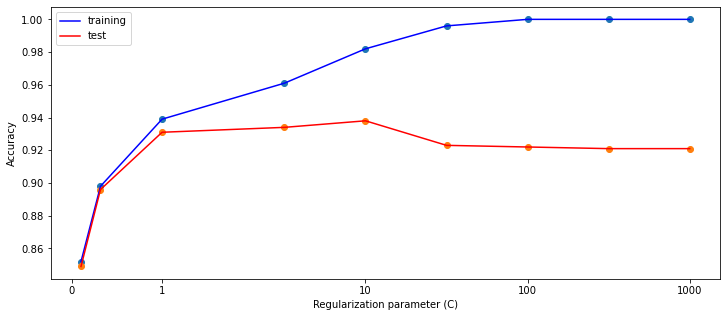

In [8]:
def plot_graph(c_values, train_accuracy, test_accuracy):
    from matplotlib import ticker # to format the graph
    
    f = plt.figure(figsize = (12, 5))
    f_x = f.add_subplot(1,1,1)
    plt.xlabel("Regularization parameter (C)")
    plt.ylabel("Accuracy")
    plt.scatter(c_values,train_accuracy)
    plt.plot(c_values,train_accuracy,label = "training", color = "blue")
    plt.scatter(c_values,test_accuracy)
    plt.plot(c_values,test_accuracy,label = "test", color = "red")
    f_x.set_xscale('symlog')
    f_x.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
    plt.legend(loc = "upper left")
    
    
plot_graph(c_array, train_acc, test_acc)